<img src="../logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Trabajo Práctico Nº4
#### Federico Borello

Hago uso de un módulo llamado `pds_utils` ubicado en el directorio base del repositorio

# Simulación de Ruido y ADC

Expandiendo el trabajo de la TS3, ahora se plantea analizar la adición del ruido analógico previo a la entrada del ADC.

Para ello, se genera un ruido uniforme y se interpreta el desvio estandar como la potencia del ruido.

Siguiendo los siguientes items:
- La señal que entra al ADC será $S_{\text{real}} = S_{\text{teórica}} + n$
  - Siendo $n$ el ruido, incorrelado y Gaussiano
- La potencia del ruido será $P_n=k \, P_q$
  - Siendo $k$ un factor de escala arbitrario
  - Siendo $P_q$ la potencia del ruido de cuantización: Al ser una distribución uniforme &rarr; $P_q = \frac{q^2}{12}$  
 
Se procede con un gráfico simple con 2 señales, la señal superior es la señal teórica y la señal inferior tiene sumado el ruido analógico creado con `np.random.normal`

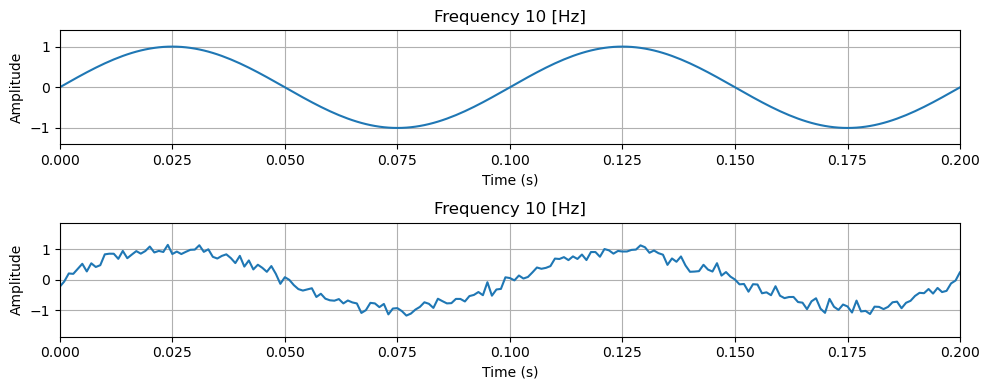

In [1]:
# @title: Generación de Ruido Uniforme Normalizado
import sys
import os

sys.path.append(os.path.abspath(".."))
from pds_utils import plotter, sine

import numpy as np

amplitude = 1
# Se alimenta el adc con vcc y vee
# Utilizando la amplitud de la señal
vcc = amplitude * 2
vee = -amplitude * 2

# Señal a cuantizar
fs = N = 1000
f = 10
t, sr = sine.wave(
    sampling_freq=fs, samples=N, amplitude=amplitude, dc_level=0, frequency=f
)

bits = 2
q = (vcc - vee) / (2**bits - 1)

random_signal = np.random.normal(0, np.sqrt(q**2 / 12 * 0.1), N)
sn = sr + random_signal

# Se grafica la señal real y con ruido
plotter.multiple([(t, sr, f), (t, sn, f)])

## Comparaciones en Tiempo

Se procede a comparar señales con diferentes $k$ y cuantizadas con ADCs de 4, 8 y 16 bits.

A medida que aumentan los bits, el error de cuantización disminuye y como el ruido analógico es $P_n \propto q \, k$, se puede decir que la potencia del ruido analógico disminuye y al ser ruido con distribución gaussiana, el ruido debería estar en todas las frecuencias pero en menor proporción.

Se utiliza $q$ de 4bits y $k$ aumenta desde $1/10$, $1$, $10$. Al usar la misma potencia de ruido para todos los ADC se puede hacer una comparación más justa.

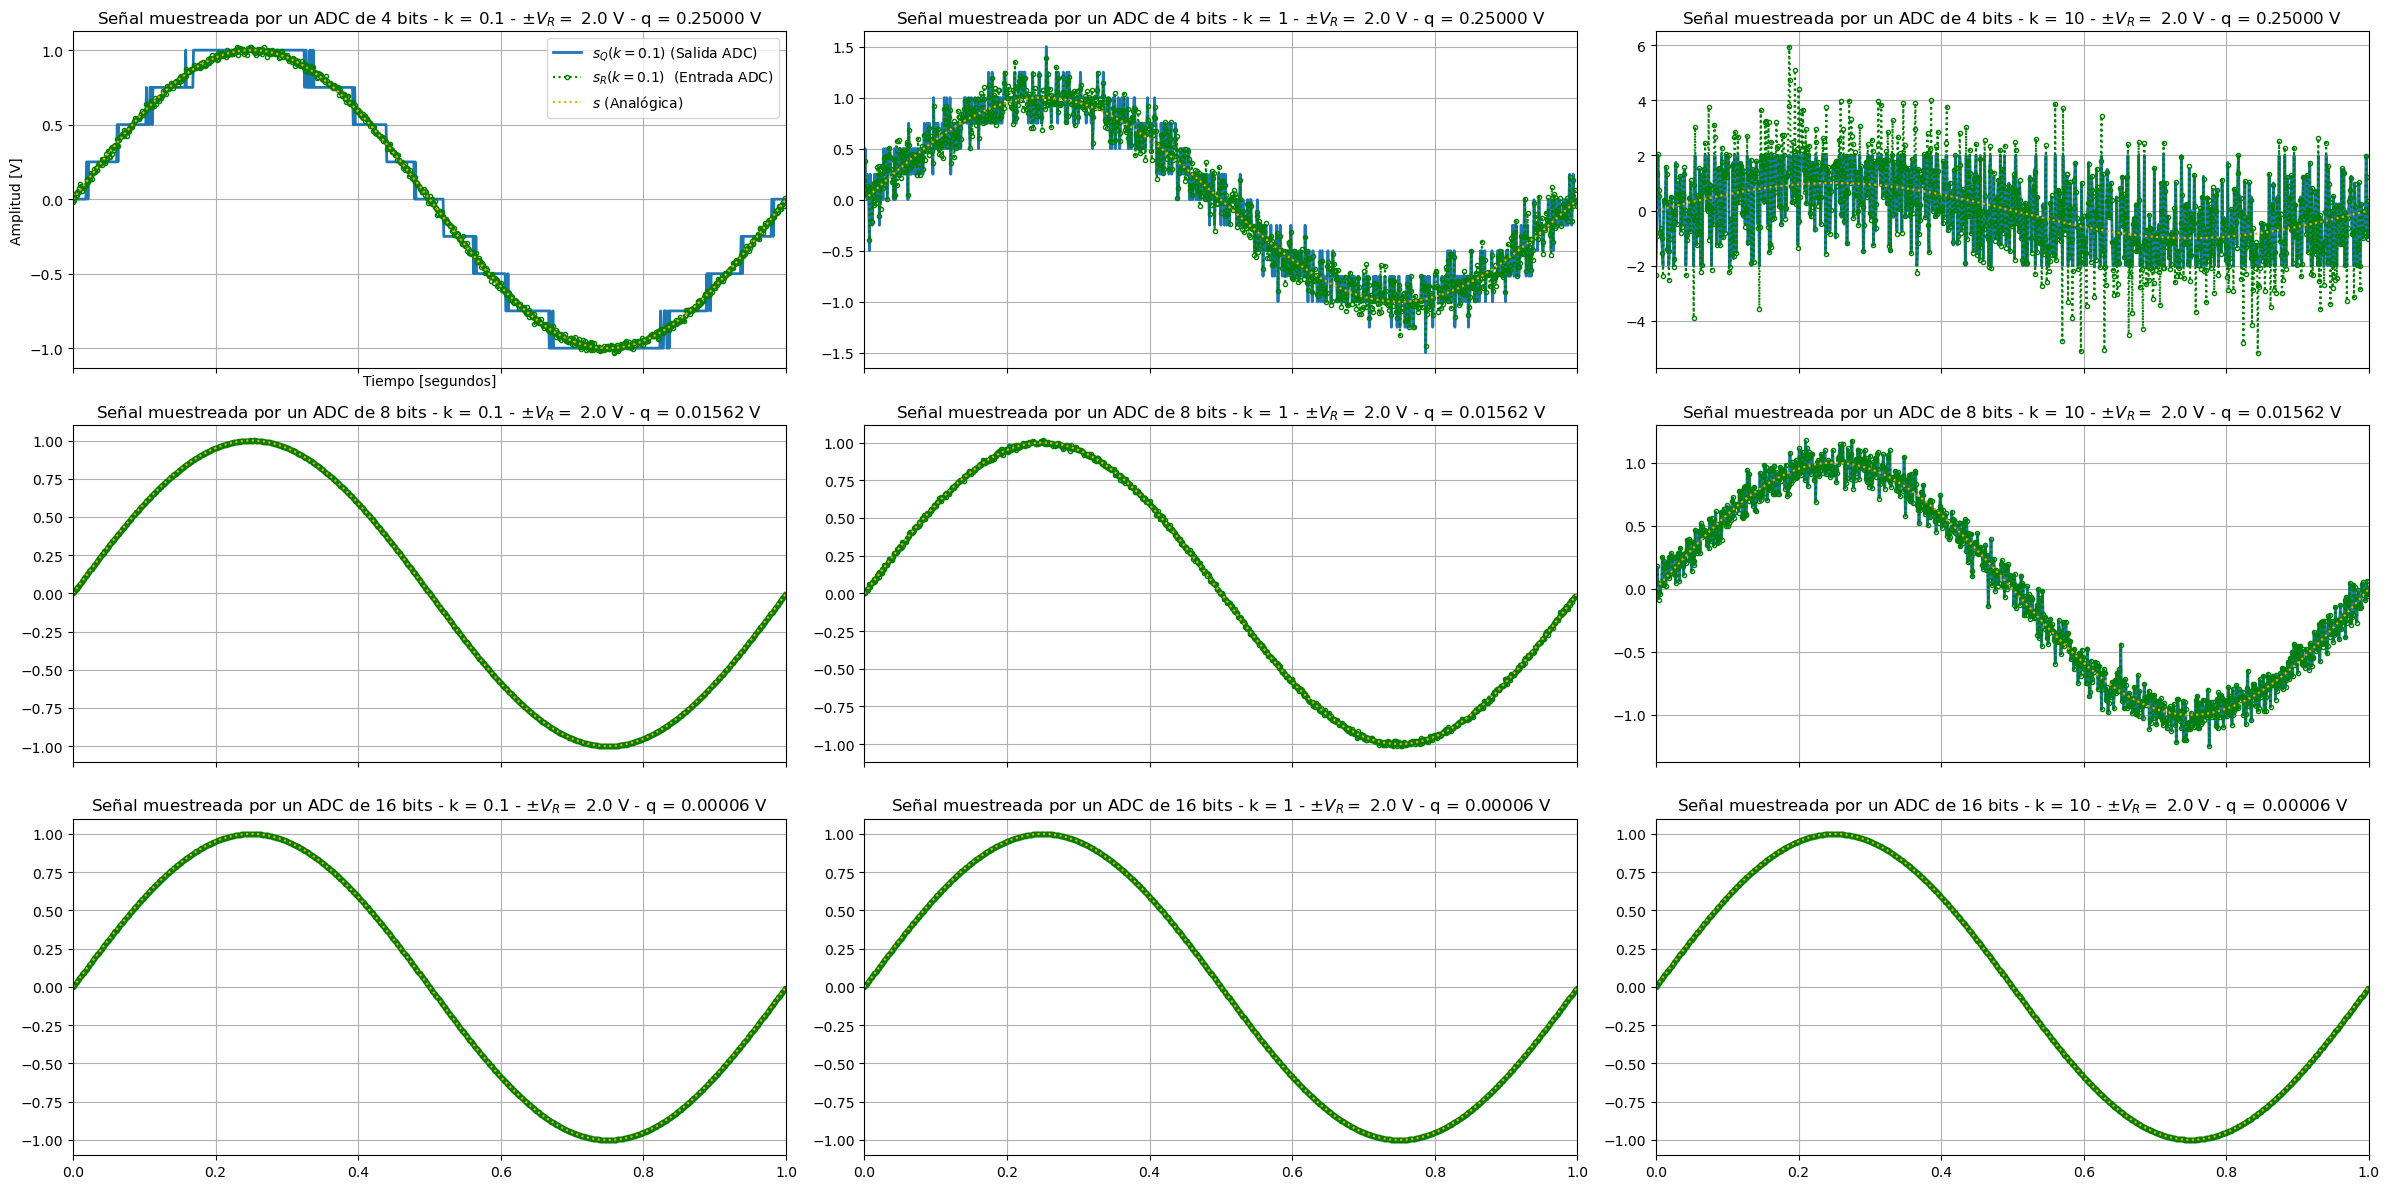

In [2]:
from pds_utils import adc, noise
from matplotlib import pyplot as plt

fs = N = 1000
f = 1
t, sr = sine.wave(
    sampling_freq=fs, samples=N, amplitude=amplitude, dc_level=0, frequency=f
)

bits = [4, 8, 16]

# Valores de k
# Valor arbitrario para generar ruido con mayor o menor potencia
k_values = [0.1, 1, 10]

# Creo subplots para cada combinación de bits y k
fig, axs = plt.subplots(len(bits), len(k_values), figsize=(24, 12), sharex=True)

sq_array = np.empty((len(bits), len(k_values), N))
sn_array = np.empty((len(bits), len(k_values), N))
n_array = np.empty((len(bits), len(k_values), N))
q_error_array = np.empty((len(bits), len(k_values), N))

q_list = [[] for _ in range(len(bits))]

for j, b in enumerate(bits):
    for i, k in enumerate(k_values):
        # Calcular potencia del ruido
        q = (vcc - vee) / (2 ** (b - 1))
        q_list[j].append(q)
        p = np.sqrt(q**2 / 12) * k

        # Aplicar ruido a la señal
        sn, n = noise.normal(sr, 0, p, N)
        sn_array[j, i] = sn
        n_array[j, i] = n

        # Cuantización de la señal con ruido
        sq, q = adc.adc(sn, bits=b, vcc=vcc, vee=vee)
        sq_array[j, i] = sq

        # Guardo los resultados del error para cada combinación de bits y k
        q_err = sr - sq
        q_error_array[j, i] = q_err

        # Graficar los resultados en el subplot correspondiente
        axs[j, i].plot(t, sq, lw=2, label=f"$ s_Q (k={k}) $ (Salida ADC)")
        axs[j, i].plot(
            t,
            sn,
            linestyle=":",
            color="green",
            marker="o",
            markersize=3,
            markerfacecolor="none",
            markeredgecolor="green",
            fillstyle="none",
            label=f"$ s_R (k={k}) $  (Entrada ADC)",
        )
        axs[j, i].plot(t, sr, color="orange", ls="dotted", label="$ s $ (Analógica)")

        # Establecer título y etiquetas para cada subplot
        axs[j, i].set_title(
            f"Señal muestreada por un ADC de {b} bits - k = {k} - $\pm V_R= $ {vcc:.1f} V - q = {q:.5f} V"
        )
        axs[j, i].grid()


# Establecer etiquetas comunes para el eje x e y
axs[0, 0].set_ylabel("Amplitud [V]")
axs[0, 0].set_xlabel("Tiempo [segundos]")
axs[0, 0].legend(loc="upper right")
plt.xlim(0, 1 / f)
plt.tight_layout()
plt.show()

## Observaciones de las figuras en el tiempo

El ruido analógico proporcional al error de cuantización es muy apreciable cuando se muestrea con 4bits, en el resto de "simulaciones", el error analógico no es apreciable a simple vista.

## Comparaciones en Frecuencia

Se procede a calcular las FFTs de cada señal, con el fin de graficar el espectro de frecuencia, para cada combinación de bits y $k$

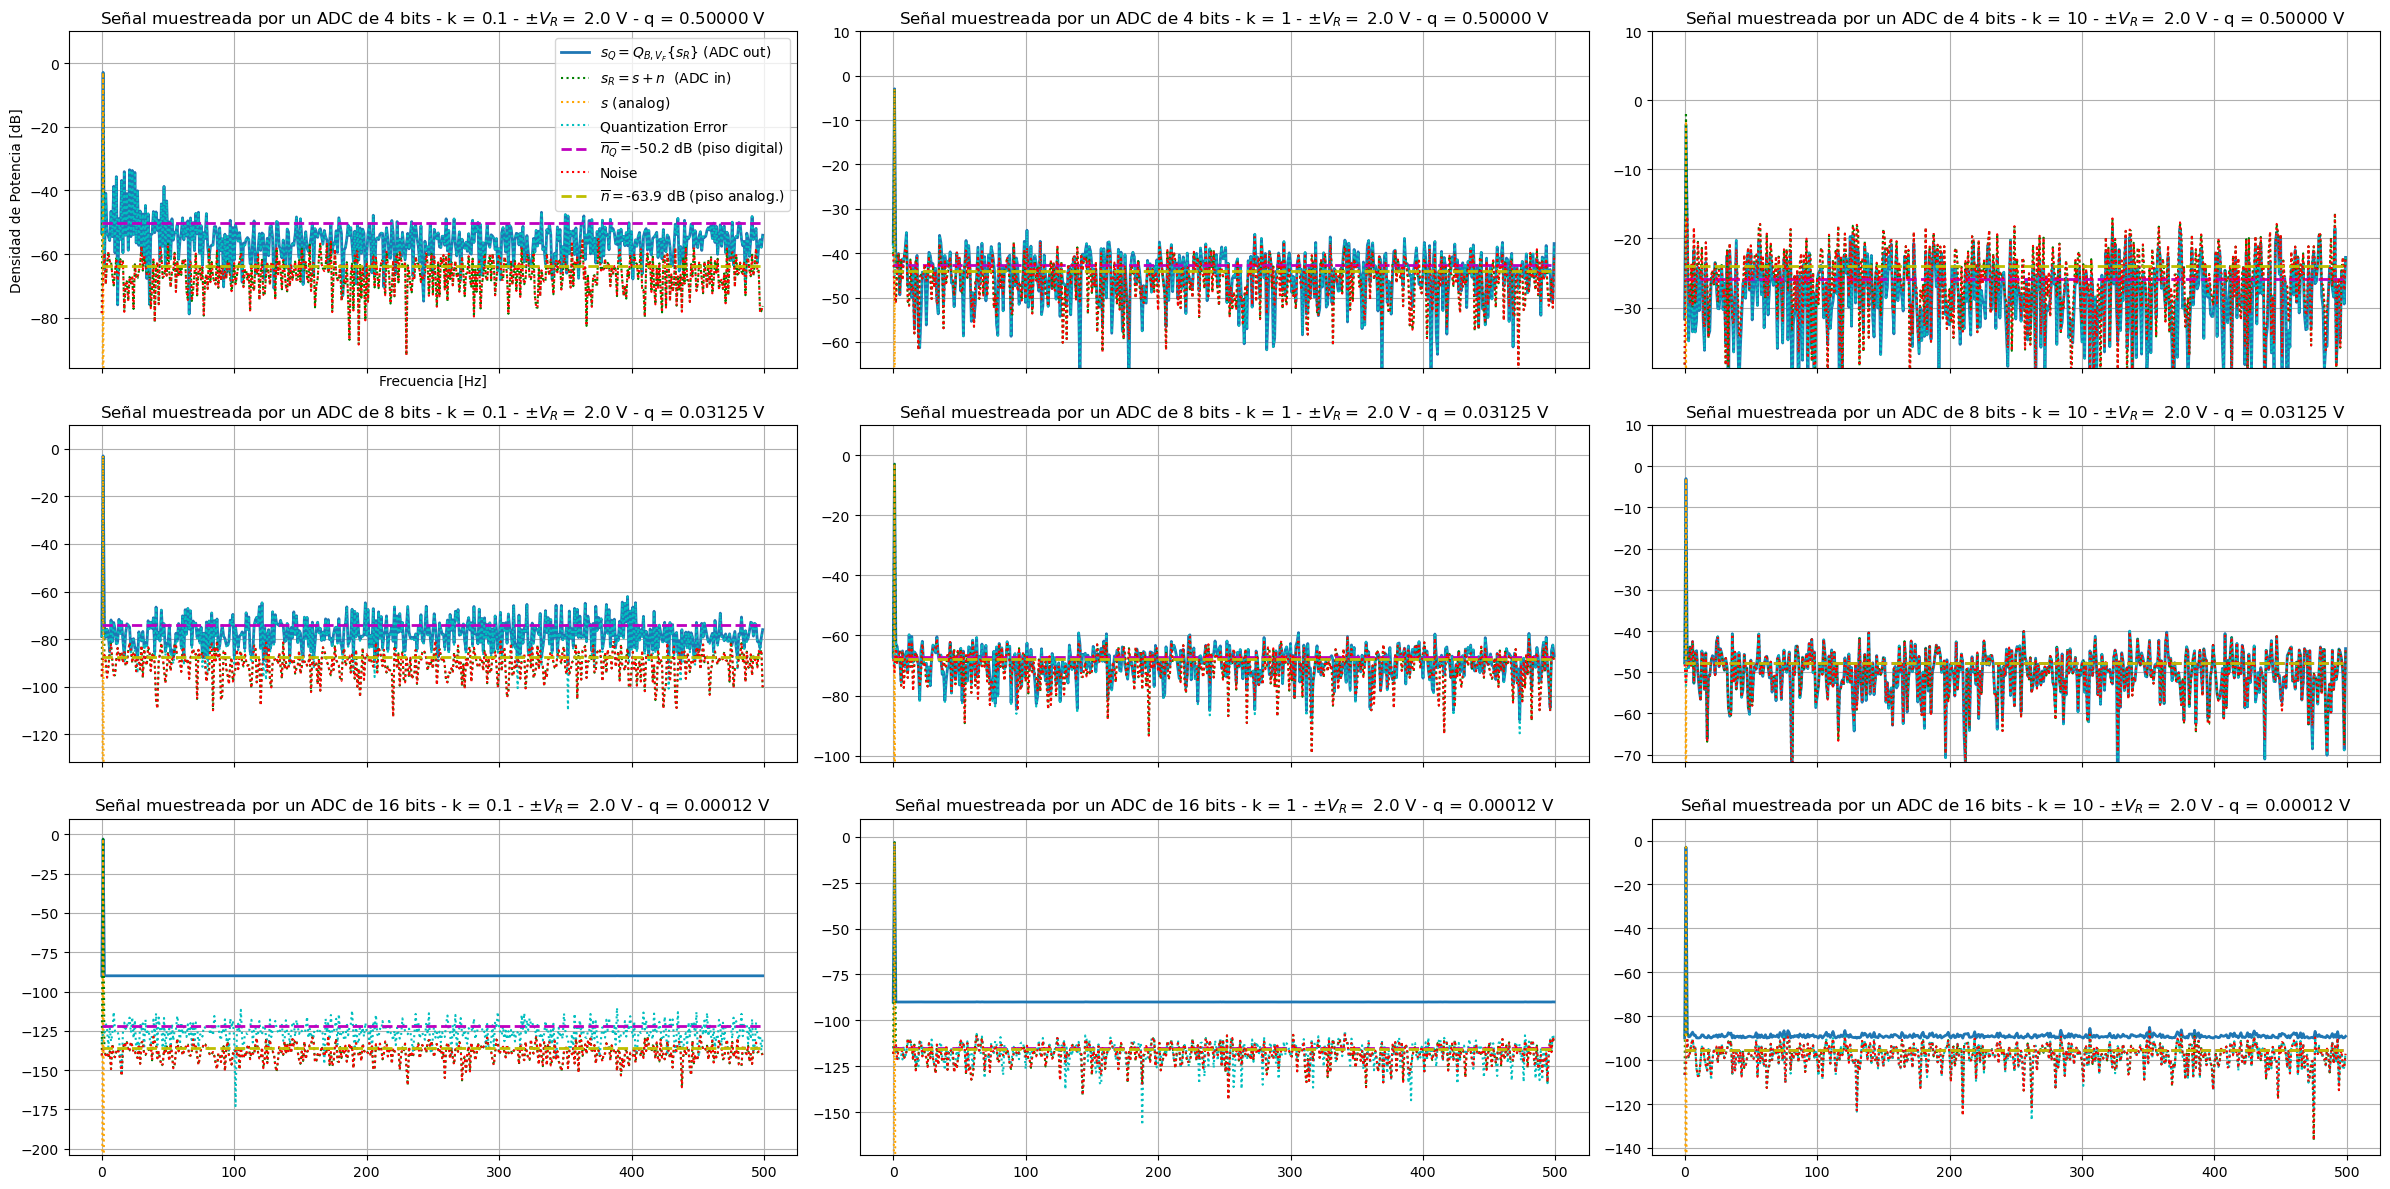

In [3]:
fig_fft, axs_fft = plt.subplots(len(bits), len(k_values), figsize=(24, 12), sharex=True)
epsilon = 1e-10  # constante para evitar log(0)
for j, b in enumerate(bits):
    for i, k in enumerate(k_values):
        # FFT calculos
        ft_Srq = np.fft.fft(sq_array[j, i]) / N
        ft_SR = np.fft.fft(sn_array[j, i]) / N
        ft_As = np.fft.fft(sr) / N
        ft_Nn = np.fft.fft(n_array[j, i]) / N

        ft_Nq = np.fft.fft(q_error_array[j, i]) / N

        Nnq_mean = np.mean(np.abs(ft_Nq) ** 2)
        nNn_mean = np.mean(np.abs(ft_Nn) ** 2)

        # Eje de frecuencia
        df = fs / N
        ff = np.linspace(0, (N - 1) * df, N)
        bfrec = ff <= fs / 2

        # Solo hasta fs/2
        half_index = N // 2

        # Ploteo las señales
        axs_fft[j, i].plot(
            ff[:half_index][bfrec[:half_index]],
            10
            * np.log10(2 * np.abs(ft_Srq[:half_index]) ** 2 + 1e-9)[bfrec[:half_index]],
            lw=2,
            label="$s_Q = Q_{B,V_F}\\{s_R\\}$ (ADC out)",
        )
        axs_fft[j, i].plot(
            ff[:half_index][bfrec[:half_index]],
            10 * np.log10(2 * np.abs(ft_SR[:half_index]) ** 2)[bfrec[:half_index]],
            ":g",
            label="$s_R = s + n$  (ADC in)",
        )
        axs_fft[j, i].plot(
            ff[:half_index][bfrec[:half_index]],
            10 * np.log10(2 * np.abs(ft_As[:half_index]) ** 2)[bfrec[:half_index]],
            color="orange",
            ls="dotted",
            label="$s$ (analog)",
        )

        axs_fft[j, i].plot(
            ff[:half_index][bfrec[:half_index]],
            10 * np.log10(2 * np.abs(ft_Nq[:half_index]) ** 2)[bfrec[:half_index]],
            ":c",
            label="Quantization Error",
        )
        axs_fft[j, i].plot(
            np.array([ff[bfrec][0], ff[bfrec][-1]]),
            10 * np.log10(2 * np.array([Nnq_mean, Nnq_mean])),
            "--m",
            lw=2,
            label="$ \overline{n_Q} = $"
            + "{:3.1f} dB (piso digital)".format(10 * np.log10(2 * Nnq_mean)),
        )
        # Titulo y leyenda
        axs_fft[j, i].set_title(
            f"Señal muestreada por un ADC de {bits[j]} bits - k = {k} - $\pm V_R=$ {vcc:.1f} V - q = {q_list[j][i]:.5f} V"
        )

        # Evito dividir por cero
        if k == 0:
            # Ajusto los límites del eje y para los gráficos de FFT
            axs_fft[j, i].set_ylim((1.5 * 10 * np.log10(2 * np.array(Nnq_mean)), 10))
        else:
            # Ajusto los límites del eje y para los gráficos de FFT
            axs_fft[j, i].set_ylim(
                (1.5 * np.min(10 * np.log10(2 * np.array([Nnq_mean, nNn_mean]))), 10)
            )
            axs_fft[j, i].plot(
                ff[:half_index][bfrec[:half_index]],
                10 * np.log10(2 * np.abs(ft_Nn[:half_index]) ** 2)[bfrec[:half_index]],
                ":r",
                label="Noise",
            )
            axs_fft[j, i].plot(
                np.array([ff[bfrec][0], ff[bfrec][-1]]),
                10 * np.log10(2 * np.array([nNn_mean, nNn_mean])),
                "--y",
                lw=2,
                label="$\overline{n} =$"
                + "{:3.1f} dB (piso analog.)".format(10 * np.log10(2 * nNn_mean)),
            )
        axs_fft[j, i].grid()

    # Etiquetas de los ejes
    axs_fft[0, 0].set_ylabel("Densidad de Potencia [dB]")
    axs_fft[0, 0].set_xlabel("Frecuencia [Hz]")
    axs_fft[0, 0].legend(loc="upper right")
plt.tight_layout()
plt.show()

## Observaciones de las figuras en frecuencia

Como fue anticipado, el piso de ruido `digital`, ruido de cuantización, disminuye a medida que se aumentan los bits, el piso analógico de ruido aumenta con $k$ mayores. 

El piso digital está por encima del piso analógico, a pesar de que la potencia del ruido analógico sea mayor con $k=10$, ya que el proceso de cuantización se realiza a la señal más el ruido analógico; el ruidó analógico influye en el proceso de cuantización y `empeora` el piso analógico (lo eleva). Esta observación se ve reflejada en el espectro superior derecho, 4 bits y $k = 10$.

## Comparaciones de Error de cuantización

Por último, se grafican los histogramas del error de cuantización "contenidos" por una linea roja punteada. La línea roja punteada, representa la distribución uniforme teórica del ruido de cuantización.

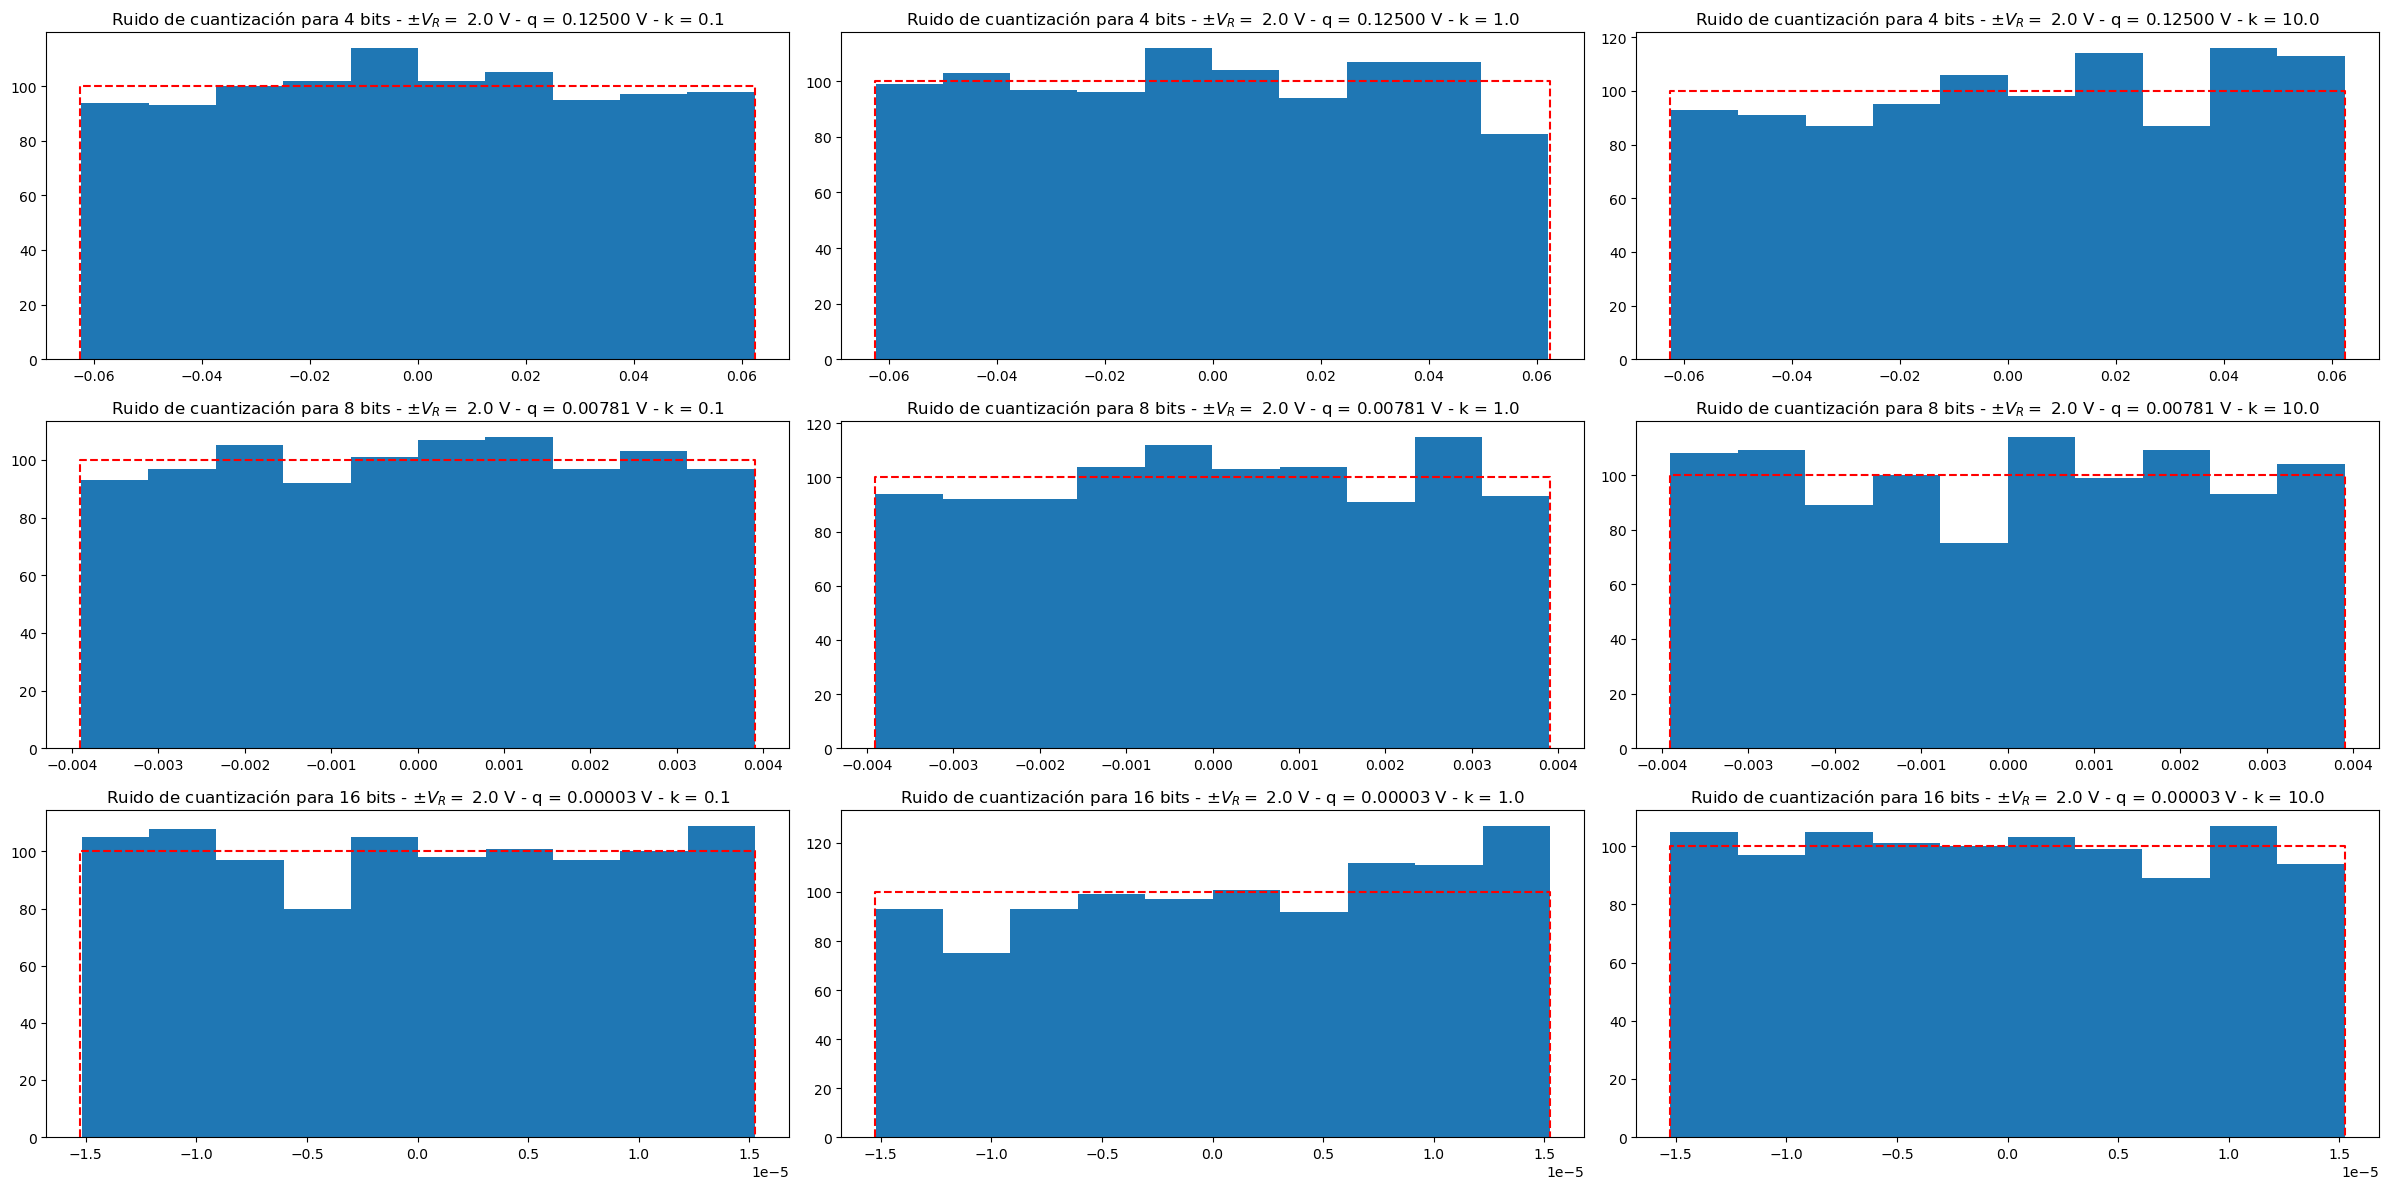

In [4]:
bins = 10

fig_hist, axs_hist = plt.subplots(len(bits), len(k_values), figsize=(24, 12))

for j, b in enumerate(bits):
    for i, k in enumerate(k_values):
        q = (vcc - vee) / (2 ** (b - 1))
        p = (q**2 / 12) * k

        # Ruido
        sr, n = noise.normal(sr, 0, np.sqrt(p), N)
        # Cuantización
        sq, q = adc.adc_no_clip(sr, b, vcc)
        # Error de cuantización
        q_err = sr - sq

        # Ploteo los histogramas
        axs_hist[j, i].hist(q_err, bins=bins)
        # Ploteo distribución uniforme en linea punteada
        axs_hist[j, i].plot(
            np.array([-q / 2, -q / 2, q / 2, q / 2]),
            np.array([0, N / bins, N / bins, 0]),
            "--r",
        )
        # Titulo
        axs_hist[j, i].set_title(
            "Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.5f} V - k = {:3.1f}".format(
                b, vcc, q, k
            )
        )
plt.tight_layout()
plt.show()

## Observaciones de los histogramas

Los errores de cuantización presentan una distribución uniforme. Causada por el proceso de cuantificación

## Observaciones generales

El análisis realizado demuestra que el ruido analógico se traslada al "mundo" digital. A mayor cantidad de bits utilizados en el ADC, menor será el ruido de cuantización. En un caso donde se tenga una señal con ruido analógico, cuya potencia sea comparable al error de cuantización de una señal con 4 bits, el ruido será generado principalmente por la componente analógica, pero "levantará" el nivel de ruido digital. La señal muestreada estará ubicada en los puntos correctos debido a la precisión del ADC de 16 bits, pero presentará una discrepancia con respecto a la señal original debido al ruido analógico presente.

En resumen, el análisis de los histogramas y las observaciones generales ponen de manifiesto la importancia de considerar tanto el ruido de cuantización como el ruido analógico en el diseño y análisis de sistemas de muestreo y cuantización de señales. La elección adecuada del número de bits del ADC y la minimización del ruido analógico son cruciales para obtener una representación digital precisa de la señal original.

###  Relación entre la cantidad de B bits del ADC y el SNR de la señal digitalizada

Holton DSP Principles and Applications 6.7 ADC Quantization pag. 387

$$\text{SNR} \triangleq 10 \log_{10} \frac{\sigma^2_x}{\sigma^2_e}$$

Si consideramos que la distribución del error de cuantización es uniforme entre $-\frac{q}{2}$ y $\frac{q}{2}$, se tiene que:

$$\sigma^2_e = \cfrac{q^2}{12}$$

$\sigma^2_x$ es el valor *RMS* de la señal.

Y 

$$q = \cfrac{V_{\text{FS}}}{2^{N-1}}$$

Donde:
- $V_{\text{FS}}$ es la tensión de alimentación del ADC
- $N$ la cantidad de bits teóricos, hay efectos reales que disminuyen este valor (ENOB)

Al reemplazar $q$ en la primera ecuación:

$$\text{SNR} = 6.02 \, N + 10.79 + 20 \log_{10} \frac{\sigma_x}{V_{\text{FS}}}$$

El último término puede no considerarse, ya que se considera un diseño optimo.En la página 387 del Holton se da una explicación más detallada de por qué el último término no es relevante en ciertos casos. 

Si se tiene una señal senoidal, $V_{\text{RMS}}= \frac{A}{\sqrt{2}}$:

Con $A = V_{\text{FS}}/2$

$$\text{SNR} = 6.02 \, N + 1.76$$

Luego, se puede definir el *ENOB*, Effective Number Of Bits:

$$N = ENOB$$

$$ENOB = \cfrac{\text{SNR}-1.76}{6.02}$$

Indica cuántos bits de resolución efectiva tiene un ADC en condiciones reales, teniendo en cuenta el ruido y las distorsiones.
Generalmente se redondea al número entero con la función `ceil`.

In [5]:
import pandas as pd

sigma_x_sq = np.std(sr)
sigma_x_theo_sq = amplitude / np.sqrt(2)

results = []

for j, b in enumerate(bits):
    for i, k in enumerate(k_values):
        q_err = q_error_array[j, i]
        sigma_q = np.std(q_err)

        q = q_list[j][i]
        sigma_q_theo = q / np.sqrt(12)

        snr = 10 * np.log10(sigma_x_sq**2 / sigma_q**2)
        snr_theo = 10 * np.log10(sigma_x_theo_sq / sigma_q_theo**2)

        enob = (snr - 1.762) / 6.02
        enob_theo = (snr_theo - 1.762) / 6.02
        enob_theo_ceil = np.ceil(enob_theo)
        enob_ceil = np.ceil(enob)

        results.append(
            {
                "Bits": b,
                "k": k,
                "SNR (dB)": snr,
                "SNR Teórico (dB)": snr_theo,
                "ENOB Real": enob,
                "ENOB Real con Ceil": enob_ceil,
                "ENOB Teórico": enob_theo,
                "ENOB Teórico con Ceil": enob_theo_ceil,
            }
        )


pd.DataFrame(results)

,Bits,k,SNR (dB),SNR Teórico (dB),ENOB Real,ENOB Real con Ceil,ENOB Teórico,ENOB Teórico con Ceil
0,4,0.1,21.784599,15.307262,3.326013,4.0,2.250044,3.0
1,4,1.0,14.343060,15.307262,2.089877,3.0,2.250044,3.0
2,4,10.0,-2.567922,15.307262,-0.719256,-0.0,2.250044,3.0
3,8,0.1,45.473997,39.389662,7.261129,8.0,6.250442,7.0
4,8,1.0,38.645102,39.389662,6.126761,7.0,6.250442,7.0
5,8,10.0,19.383858,39.389662,2.927219,3.0,6.250442,7.0
6,16,0.1,93.474513,87.554461,15.234637,16.0,14.251239,15.0
7,16,1.0,86.429446,87.554461,14.064360,15.0,14.251239,15.0
8,16,10.0,67.136320,87.554461,10.859522,11.0,14.251239,15.0


Analizando los datos del ADC de `16bits` se aprecia cómo afecta el ruido analógico a la digitalización, el ENOB de 10 implica que el ADC de 16 bits actúa como un ADC de menos bits en la realidad.